In [61]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import recall_score, classification_report
import string

## 1. Load the dataset

In [3]:
# load datasets given
df_movie_details = pd.read_json("../data/IMDB_movie_details.json", lines = True)
df_reviews = pd.read_json("../data/IMDB_reviews.json", lines = True)

In [3]:
df_movie_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   release_date   1572 non-null   object 
 6   plot_synopsis  1572 non-null   object 
dtypes: float64(1), object(6)
memory usage: 86.1+ KB


In [4]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB


In [4]:
df_reviews['is_spoiler'].value_counts()

False    422989
True     150924
Name: is_spoiler, dtype: int64

In [5]:
df_reviews = pd.read_pickle("../data/tokenized_reviews.pkl.gz", compression = 'gzip')

## 2. Text Preprocessing

### Tokenize review texts

In [3]:
# TOKENIZING WILL TAKE ~15 MINUTES
# If you want to save after tokenizing feel free to do so to save time in tokenizing again
df_reviews['tokenized_summary'] = list(map(word_tokenize, df_reviews['review_summary']))
df_reviews['tokenized_reviews'] = list(map(word_tokenize, df_reviews['review_text']))

### Removing stop words and punctuations from the list

In [6]:
# get stop words
stop_words_and_punctuations = set(stopwords.words('english') + list(string.punctuation))

In [7]:
# remove stop words and punctuations from the tokenized list
df_reviews['tokenized_summary'] = list(map(lambda x: [word.lower() for word in x if word.lower() not in stop_words_and_punctuations], df_reviews['tokenized_summary']))
df_reviews['tokenized_reviews'] = list(map(lambda x: [word.lower() for word in x if word.lower() not in stop_words_and_punctuations], df_reviews['tokenized_reviews']))

### Stemming or Lemmatisation -- (to be implemented)

In [6]:
# stem or lemmatise words
stemmer = PorterStemmer()
df_reviews['tokenized_summary'] = list(map(lambda x: [stemmer.stem(word) for word in x], df_reviews['tokenized_summary']))
df_reviews['tokenized_reviews'] = list(map(lambda x: [stemmer.stem(word) for word in x], df_reviews['tokenized_reviews']))

### Save the new dataset

In [8]:
# save changes made to original dataset to save time tokenizing etc
df_reviews.to_pickle("../data/cleaned_reviews.pkl.gz", compression = 'gzip')

In [12]:
df_movie_details["release_date"] = pd.to_datetime(df_movie_details["release_date"])

In [25]:
(df_movie_details["release_date"] < "2015-01-01").value_counts()

True     1391
False     181
Name: release_date, dtype: int64

In [5]:
train_movies = df_movie_details["movie_id"].loc[df_movie_details["release_date"] < "2015-01-01"]
test_movies = df_movie_details["movie_id"].loc[df_movie_details["release_date"] >= "2015-01-01"]

In [48]:
df_reviews.groupby('movie_id')["is_spoiler"].value_counts()["tt0012349"]

is_spoiler
False    78
True     26
Name: is_spoiler, dtype: int64

In [6]:
df_reviews_spoiler = df_reviews.loc[df_reviews['is_spoiler'] == True]
df_reviews_non_spoiler = df_reviews.loc[df_reviews['is_spoiler'] == False]

In [15]:
df_reviews_non_spoiler = df_reviews_non_spoiler.sample(n = df_reviews_spoiler["is_spoiler"].count(), random_state = 42)
df_reviews_sampled = pd.concat([df_reviews_spoiler, df_reviews_non_spoiler])

## 3. Model Building

In [4]:
# Load the previously saved dataset
df_reviews = pd.read_pickle("../data/cleaned_reviews.pkl.gz", compression = 'gzip')

### Transform texts to numbers

In [64]:
df_reviews["text_tokenized"] = list(map(lambda x: ' '.join(x), df_reviews['tokenized_reviews']))

In [5]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(df_reviews["text_tokenized"])

### Create Model

In [17]:
X_train, X_test, y_train, y_test = train_test_split(bow, df_reviews.loc[:, 'is_spoiler'], test_size = 0.2)

In [18]:
logistic_model = LogisticRegression(max_iter = 1e3)
logistic_model.fit(X_train, y_train)

C:\Users\Vincent\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000.0)

In [19]:
logistic_model.score(X_test, y_test)

0.7660890549994337

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
#sampling

In [16]:
df_reviews_sampled["text_tokenized"] = list(map(lambda x: ' '.join(x), df_reviews_sampled['tokenized_reviews']))

In [17]:
df_train = df_reviews_sampled.loc[df_reviews_sampled["movie_id"].isin(train_movies)]
df_test = df_reviews_sampled.loc[df_reviews_sampled["movie_id"].isin(test_movies)]

In [18]:
vectorizer = CountVectorizer()
bow_train = vectorizer.fit_transform(df_train["text_tokenized"])
bow_test = vectorizer.transform(df_test["review_text"])

In [19]:
logistic_model = LogisticRegression()
logistic_model.fit(bow_train, df_train["is_spoiler"])

C:\Users\Vincent\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [20]:
logistic_model.score(bow_test, df_test["is_spoiler"])

0.6156562200629533

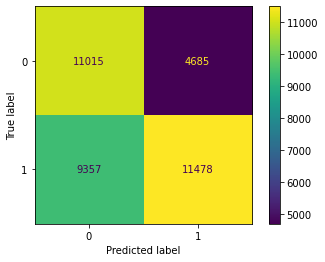

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(df_test["is_spoiler"], logistic_model.predict(bow_test))).plot()

In [22]:
recall_score(df_test["is_spoiler"], logistic_model.predict(bow_test))
print(classification_report(df_test["is_spoiler"], logistic_model.predict(bow_test)))

              precision    recall  f1-score   support

       False       0.54      0.70      0.61     15700
        True       0.71      0.55      0.62     20835

    accuracy                           0.62     36535
   macro avg       0.63      0.63      0.62     36535
weighted avg       0.64      0.62      0.62     36535



In [91]:
from sklearn import svm
clf = svm.SVC(kernel = 'rbf', max_iter = 1e4)
clf.fit(bow_train, df_train["is_spoiler"])

C:\Users\Vincent\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(max_iter=10000.0)

In [92]:
clf.score(bow_test, df_test["is_spoiler"])

0.4013957799465678

In [29]:
bow_train

<265312x201466 sparse matrix of type '<class 'numpy.int64'>'
	with 31192685 stored elements in Compressed Sparse Row format>

In [24]:
import tensorflow as tf

In [39]:
model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape = (bow_train.shape[1],), sparse = True),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])

In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer='adam',
             metrics=['accuracy'])

In [38]:
coo = bow_train.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
sparse_train = tf.SparseTensor(indices, coo.data, coo.shape)

coo = bow_test.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
sparse_test = tf.SparseTensor(indices, coo.data, coo.shape)

In [51]:
model.fit(sparse_train, df_train["is_spoiler"].to_numpy(), validation_data = (sparse_test, df_test["is_spoiler"].to_numpy()), epochs = 1)

8291/8291 [==============================] - 2155s 260ms/step - loss: 0.5723 - accuracy: 0.7003 - val_loss: 0.6215 - val_accuracy: 0.6575


In [58]:
loss, accuracy = model.evaluate(sparse_train, df_train["is_spoiler"].to_numpy(), verbose = False)
accuracy

0.7784231305122375

In [60]:
model.evaluate(sparse_test, df_test["is_spoiler"].to_numpy(), verbose = False)

[0.6215207576751709, 0.6575338840484619]

In [65]:
y_pred = model.predict(sparse_test, verbose = False) > 0.5
y_pred = y_pred.astype('int')

In [67]:
print(classification_report(df_test["is_spoiler"], y_pred))

              precision    recall  f1-score   support

       False       0.60      0.60      0.60     15700
        True       0.70      0.70      0.70     20835

    accuracy                           0.66     36535
   macro avg       0.65      0.65      0.65     36535
weighted avg       0.66      0.66      0.66     36535

